# `Семинар 3.1: Обработка звука`

### `Оганов Александр, кафедра ММП ВМК МГУ`

#### `За основу взяты материалы Максима Находнова, Ильи Алексеева кафедра ММП ВМК МГУ`

[Источник GitHub](https://github.com/mmp-practicum-team/mmp_practicum_spring_2024/blob/c3205ef68e4e4fcd24fea6947f144dee7f6f7930/Seminars/Seminar%2011/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0%20%D0%B7%D0%B2%D1%83%D0%BA%D0%B0.ipynb)




План занятия:
- Task Overview:
  - loading waveform
  - spectrogram
- Other tasks:
  - taxonomy of tasks
  - ASR (CTC, LAS, RNNT)

In [1]:
# ! apt-get update && apt-get install -y libsox-dev
# ! pip3 install timm -q

In [2]:
import os

import json

import torch
import torchaudio

import librosa

import numpy as np

from IPython.display import display, Audio

import matplotlib_inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [3]:
if torch.cuda.is_available():
    print('found CUDA!')
    device = torch.device('cuda', 0)
else:
    print('only CPU :(')
    device = torch.device('cpu')

found CUDA!


## `Введение: немного истории`

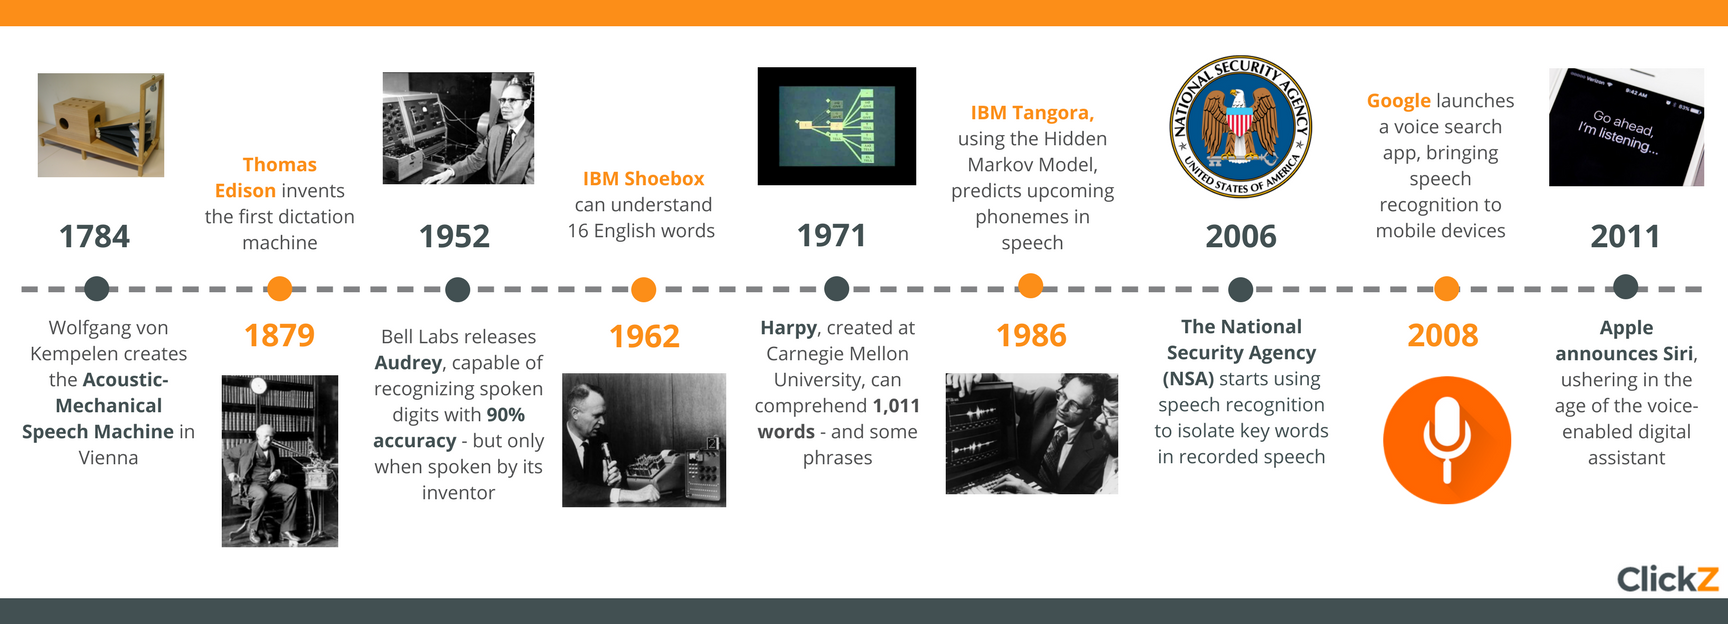

 ## `Audio`

### `Load Waveform`

In [4]:


def plot_signal(x, sr):
    fig, ax = plt.subplots(figsize=(len(x) / sr, 2.5))
    ax.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')

    
    plt.show()

In [5]:
x, sr = torchaudio.load("./audio2.wav")

# Conversion to correct sample rate...
effects = [
    ['gain', '-n', '0'],        # apply 10 db attenuation
    ['remix', '-'],             # merge all the channels
    ['rate', '16000']
]
x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)

audio = x[0]
audio.shape

torch.Size([60800])

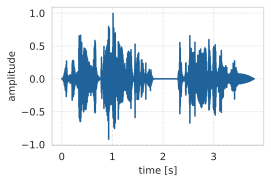

In [6]:
plot_signal(audio, 16000)

In [7]:
x, sr = torchaudio.load("./audio1.wav")

# Conversion to correct sample rate...
effects = [
    ['gain', '-n', '0'],        # apply 10 db attenuation
    ['remix', '-'],             # merge all the channels
    ['rate', '16000']
]
x, sr = torchaudio.sox_effects.apply_effects_tensor(x, sr, effects)

audio = x[0]
audio.shape

torch.Size([118400])

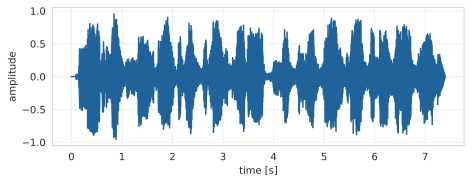

In [8]:
plot_signal(audio, 16000)

In [9]:
display(Audio(audio, rate=16000))

Этот сигнал получен в результате дискретизации колебаний мембраны:

<img src="https://static.sciencelearn.org.nz/images/images/000/004/098/full/PHYSICS_SOUND_ART_02_Dynamic_Microphone_v3.jpg?1674173130" width=600/>

Подробнее про волноформу: https://youtu.be/bnHHVo3j124?si=WBYrFM3U7VBCsxdL

### `Signal characteristics`

Имеем дискретный сигнал $\{f_{n}\}_{1:T}$ длины T. Тогда энергия и мощность будут определяться как $$E = \sum_{n=1}^{T} f_n^2 \quad P = \frac{1}{T} \sum_{n=1}^{T} f_n^2$$

Мощность также имеет смысл дисперсии.

Преобразование мощности сигнала в децибелы: $P(dB) = 10\log_{10}P$

### `VAD`

Voice Activity Detection - нарезание сигнала на слова пользуясь скользящим окном энергии.

In [10]:
import matplotlib.patches as patches

def plot_signal_energies(x, sr, energies_db, window_size=512, intervals=None):
    fig, ax = plt.subplots(figsize=(len(x) / sr, 2.5))
    ax.plot(x, color='#20639b', label='audio signal')
    plt.xticks(np.arange(0, len(x), sr), np.int32(np.arange(0, len(x), sr) / sr))
    plt.grid(alpha=0.5, linestyle='--')
    plt.xlabel('time [s]')
    plt.ylabel('amplitude')
    # plt.ylim([-0.51, 0.51])
    # plt.xlim(-50, len(x) + 50)
    if intervals:
        for a, b in intervals:
            ax.add_patch(patches.Rectangle(
                (a, -0.5), b - a, 50,
                linewidth=2, edgecolor='red',
                facecolor='none'
            ))

    plt.twinx()
    plt.plot(
        np.linspace(0, len(x), len(energies_db)),
        energies_db,
        color='#3caea3',
        label=f'energy (window size = {window_size})'
    )
    plt.ylabel('Energy [dB]')
    plt.legend(loc='best')
    plt.show()

In [11]:
def get_decibels(x):
    return 10 * np.log10(x)

In [12]:
def get_energies(x: np.array, win_size):
    res = []
    for i in range(len(x) // win_size + 1):
        start = i * win_size
        end = start + win_size
        x_win = x[start:end]
        res.append(np.sum(x_win ** 2))
    res = res[:-1]
    res = np.stack(res, axis=0)
    return res

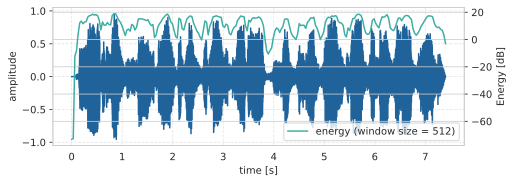

In [13]:
wave = audio.numpy()
win_size = 512
energies = get_energies(wave, win_size=win_size)
energies_db = get_decibels(energies)
plot_signal_energies(wave, 16000, energies_db, window_size=win_size)
display(Audio(wave, rate=16000))

In [14]:
audio.shape

torch.Size([118400])

### `Spectrogram from STFT`

Спектрограмма в реальном времени: https://musiclab.chromeexperiments.com/spectrogram/

- amplitude
- frquency
- phase

In [15]:
import torchaudio.transforms as T
from torch import nn


audio_transforms = nn.Sequential(
    T.MelSpectrogram(n_mels=32),
    T.AmplitudeToDB(),
)

In [16]:
features = audio_transforms(audio)

torch.Size([32, 593])


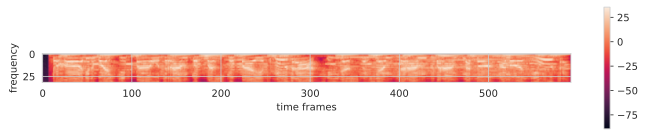

In [17]:

print(features.shape)

plt.figure(figsize=(10, 2))
ax = plt.imshow(features.numpy())

plt.gcf().colorbar(ax, location='right')

plt.xlabel('time frames')
plt.ylabel('frequency')
plt.tight_layout()
plt.show()

Спектрограмма - очень богатое и интерпретируемое признаковое описание сигнала. Некоторые специалисты по цифровой обработке сигнала могут по спектрограмме понять, какой текст был произнесён.

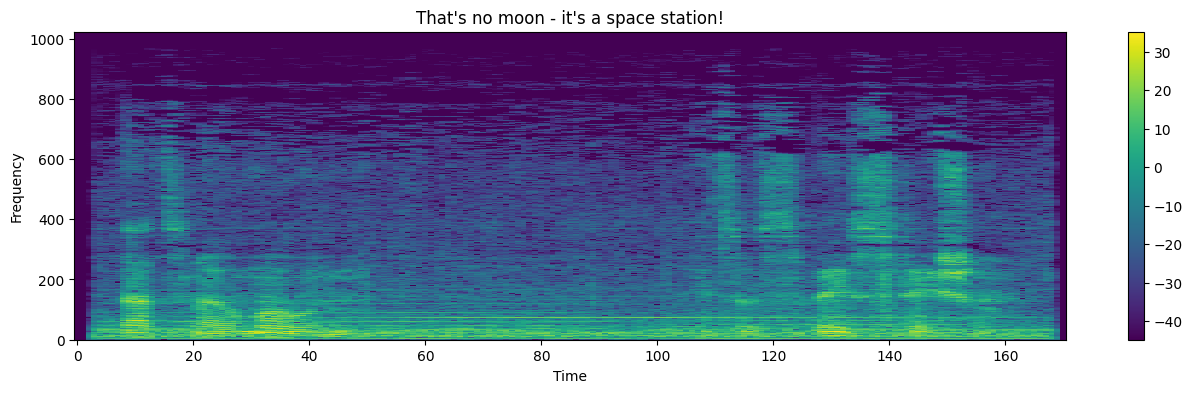

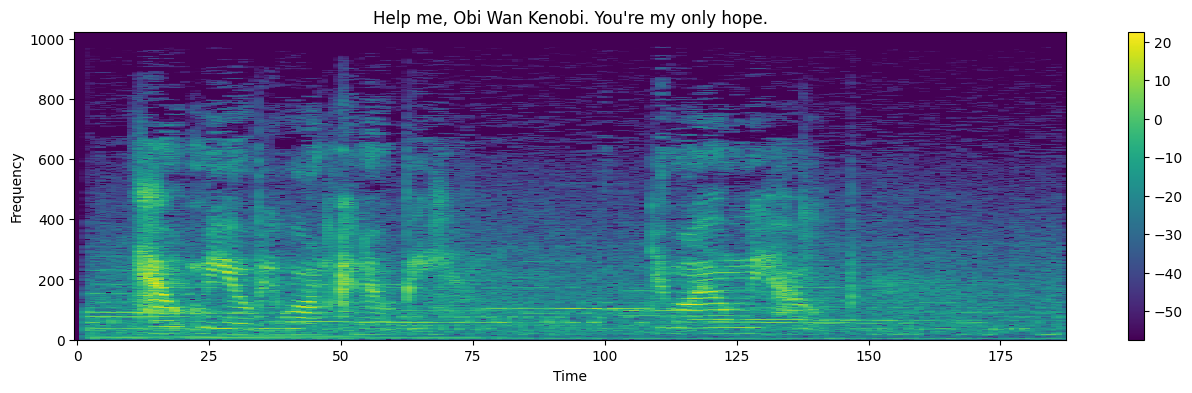

Подробно и с огоньком про STFT: https://youtu.be/-Yxj3yfvY-4?si=UkMwvXb8VCFFZ5Jr

## `Основные задачи DL audio`

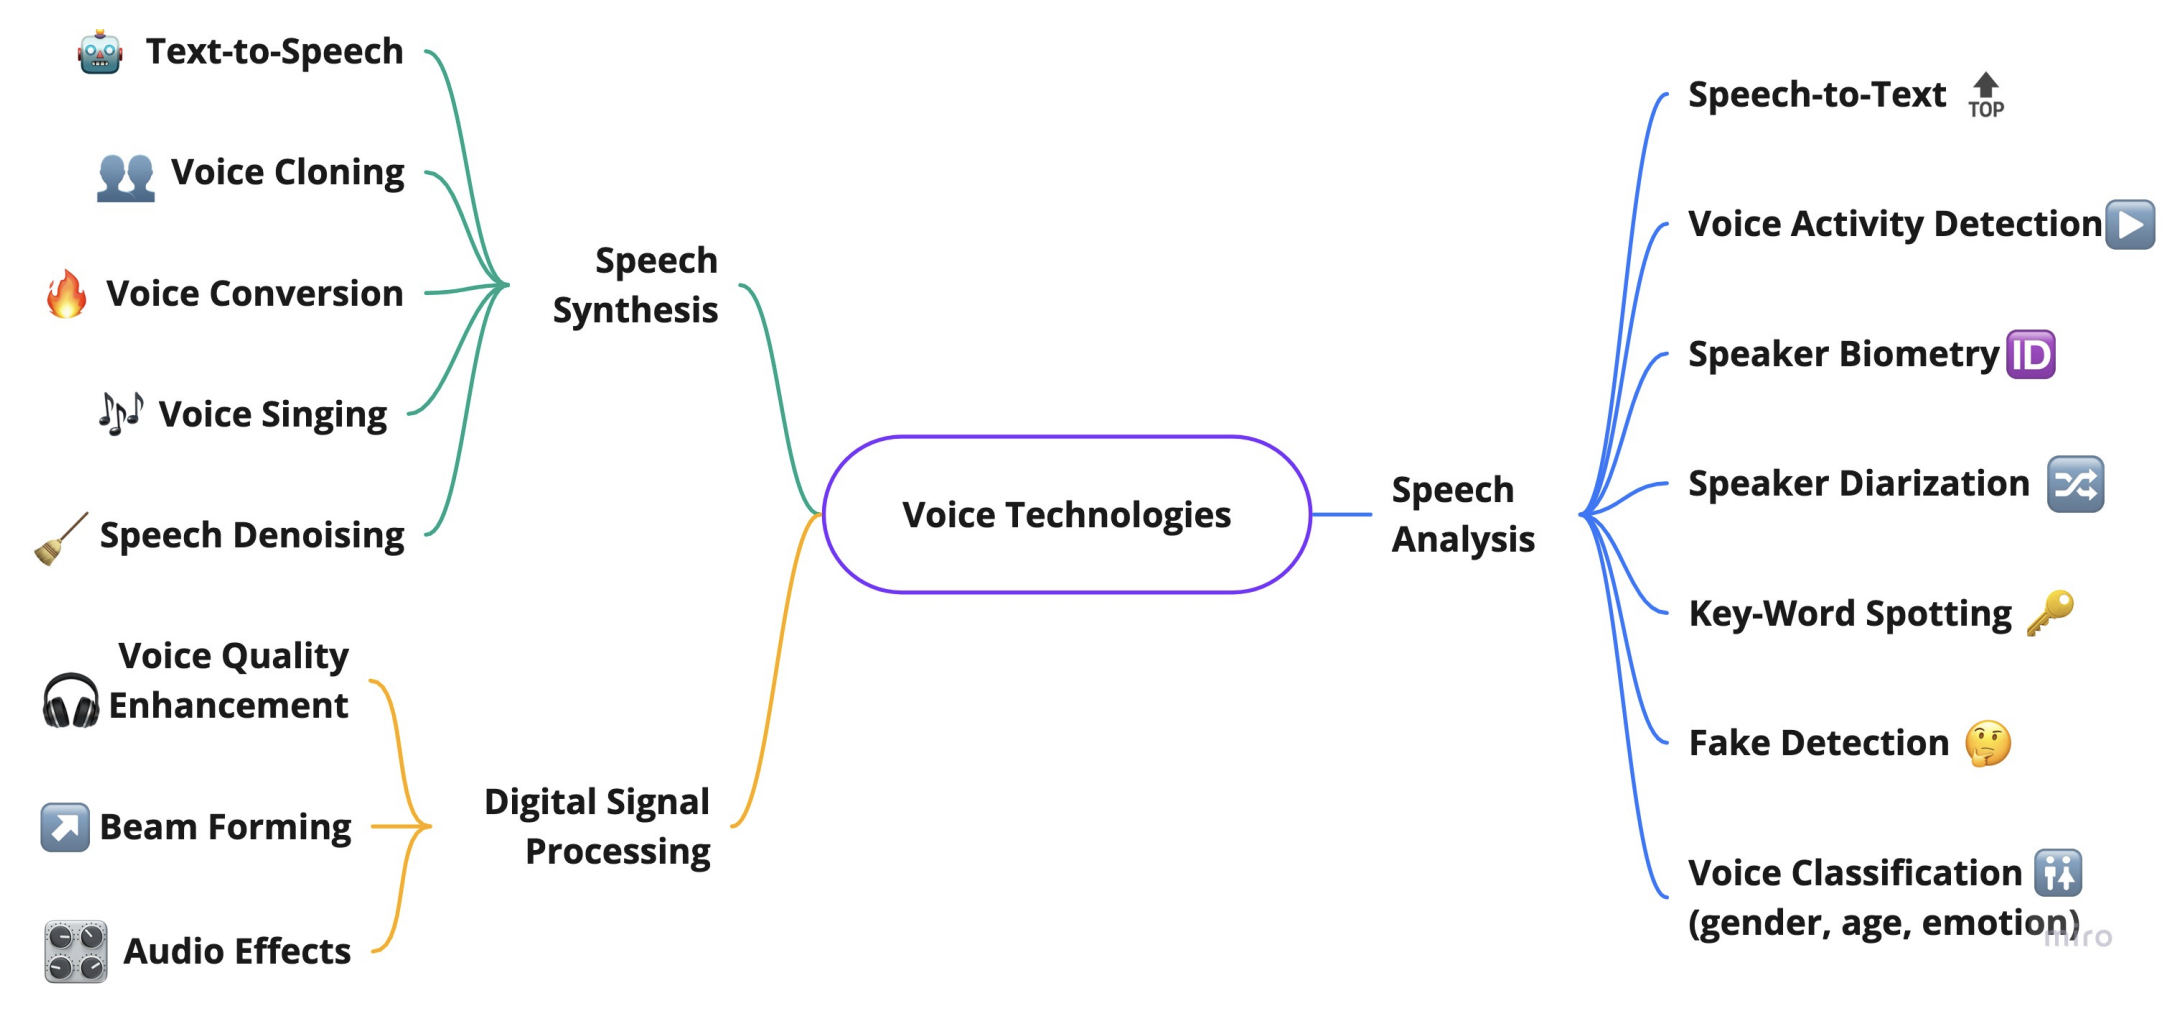

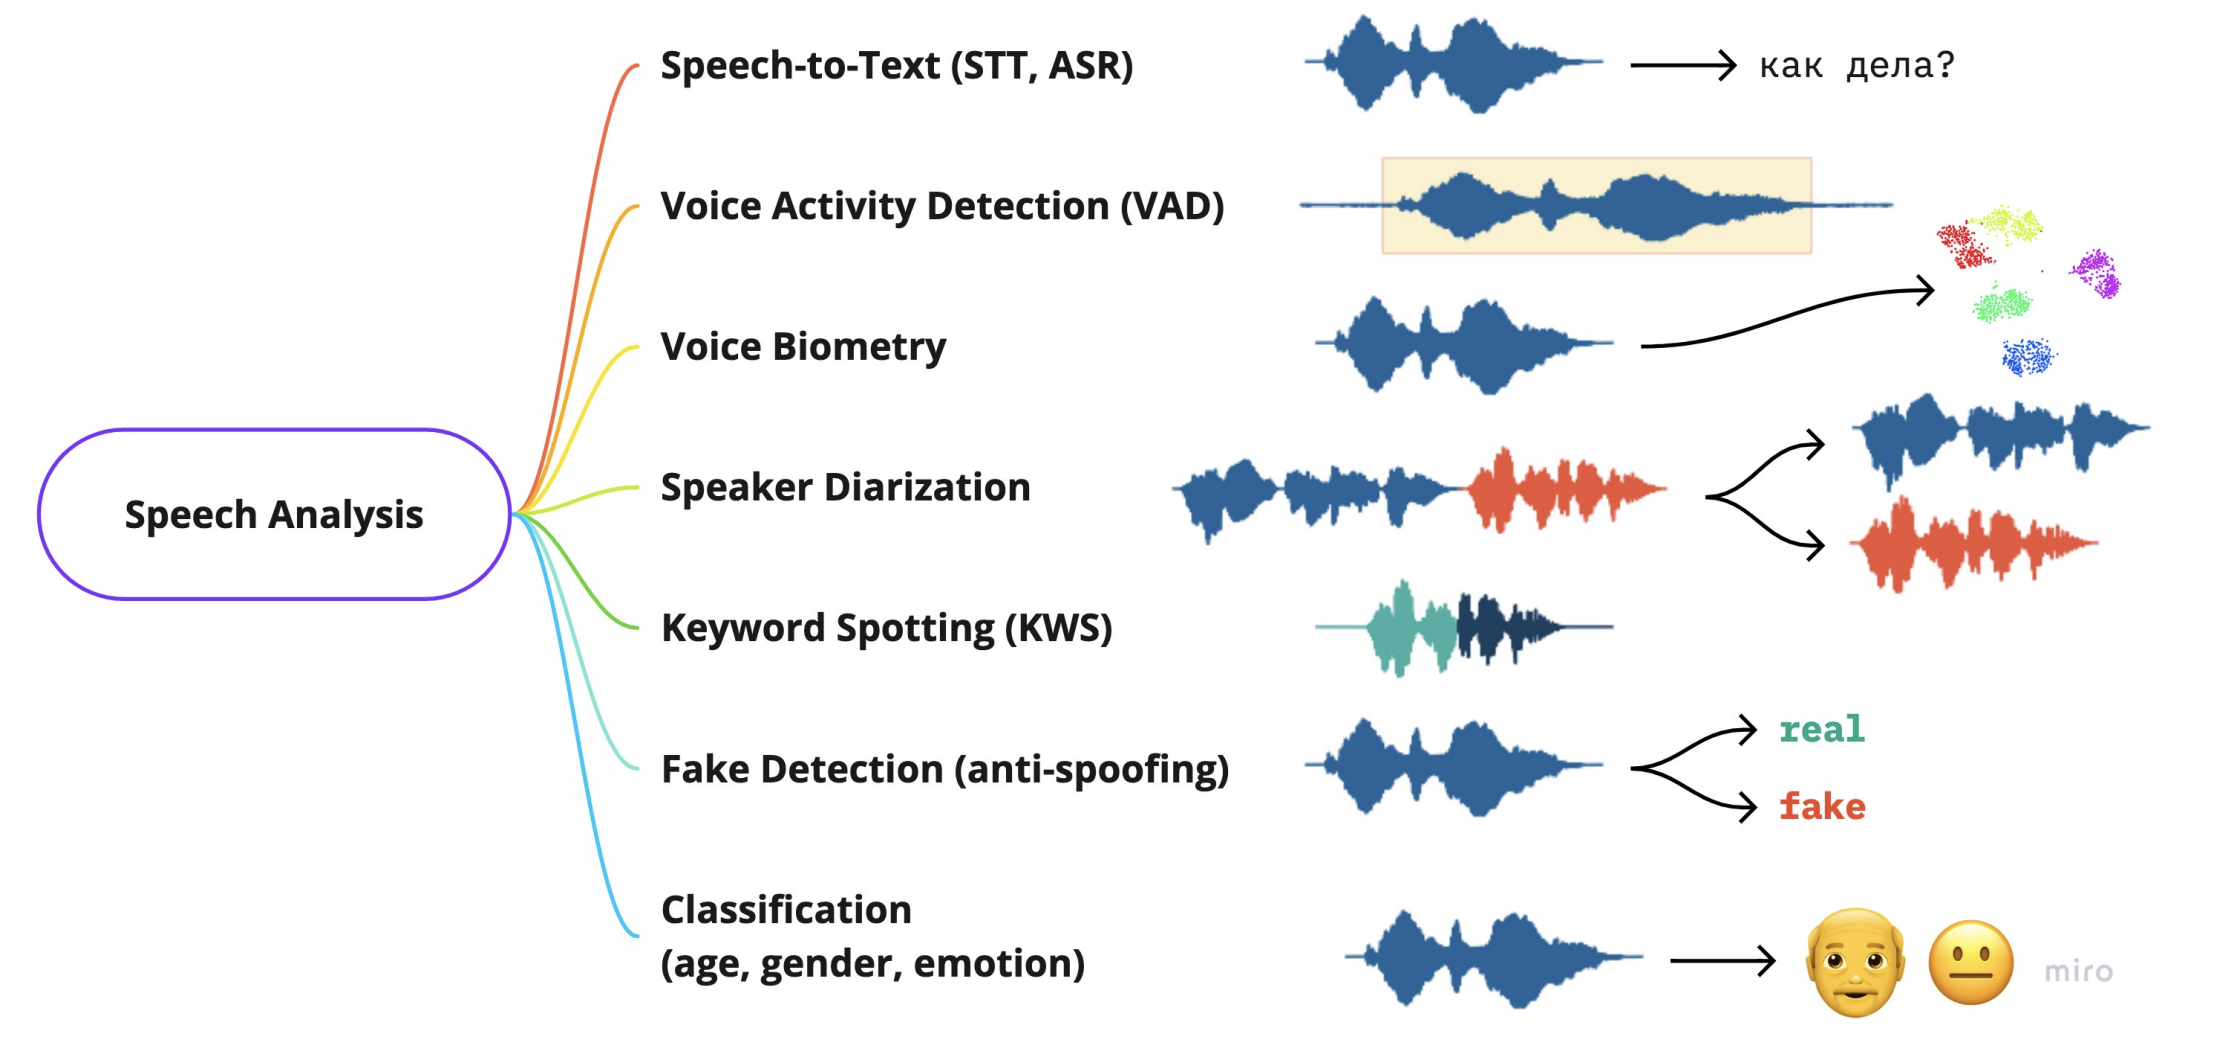

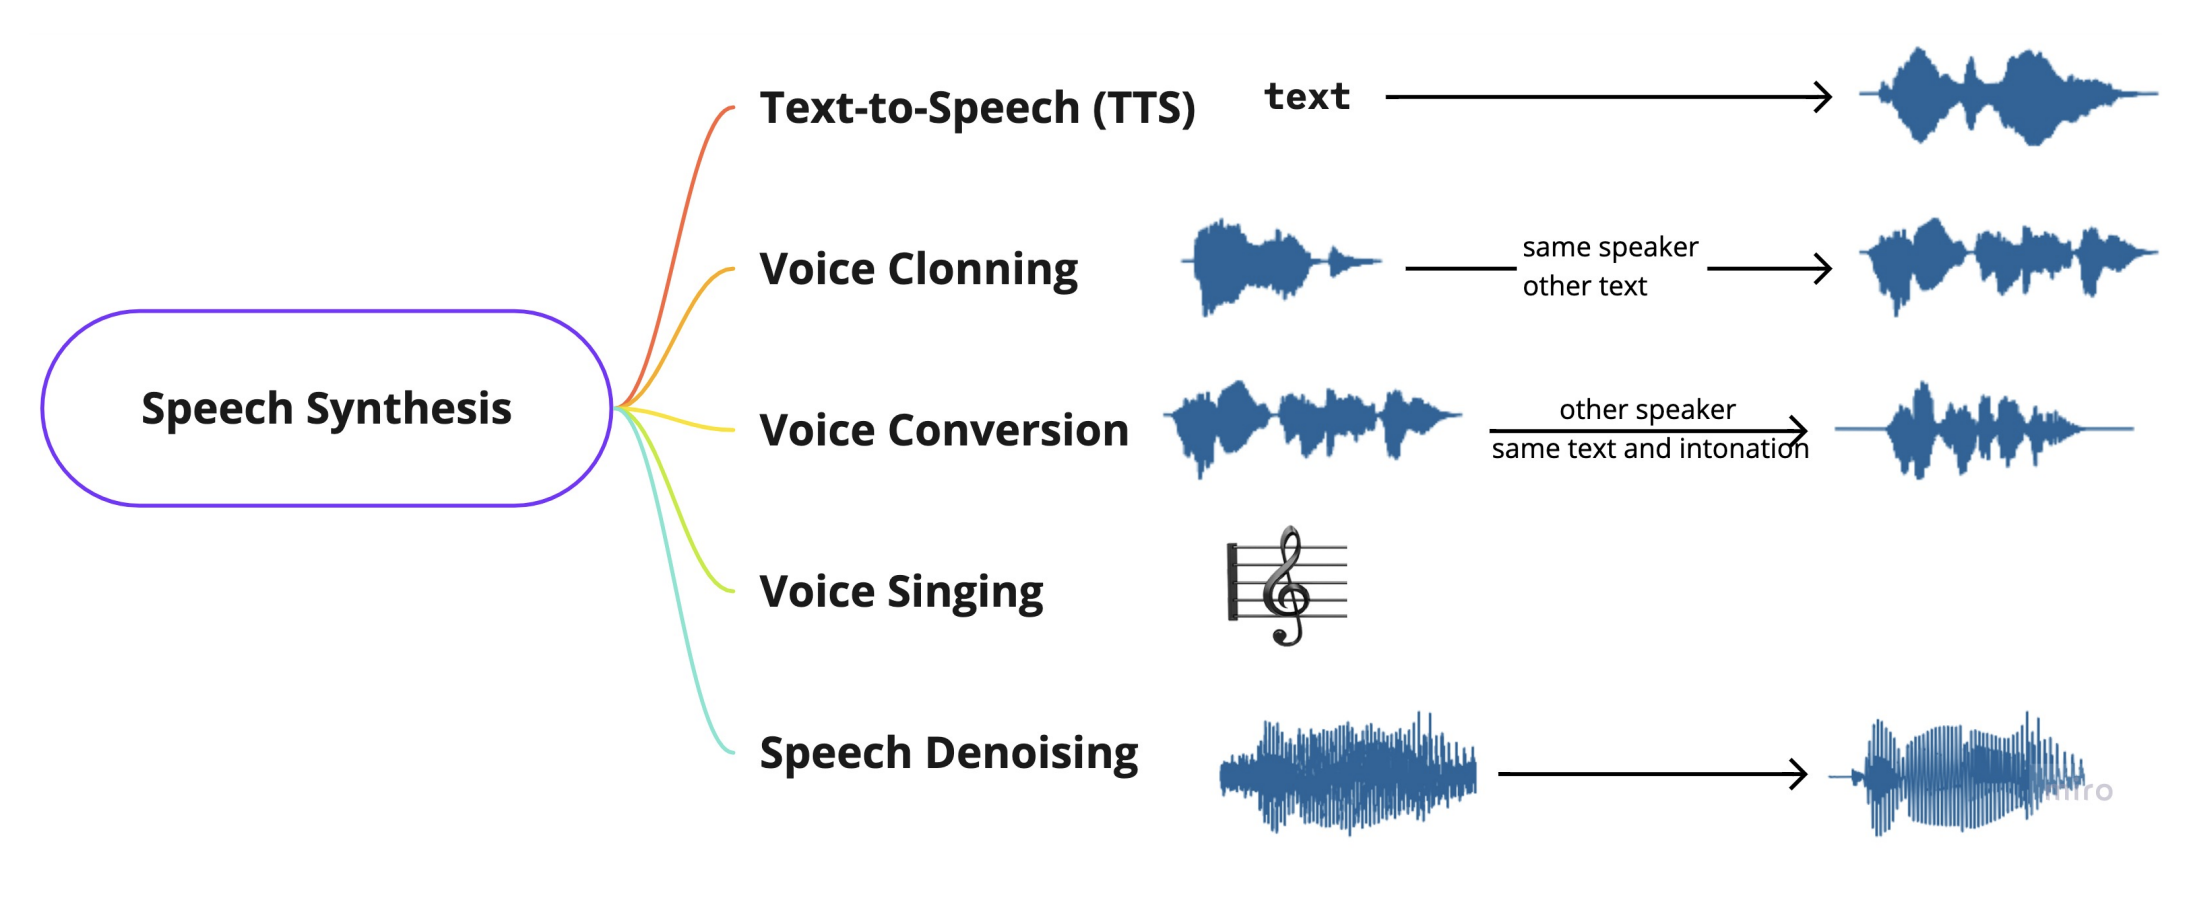

## `Automatic Speech Recognition (ASR)`

Постановка задачи:

![](https://developer.nvidia.com/blog/wp-content/uploads/2019/12/Conversation_AI_Workflow_v02.png)

Типичная архитектура:

<img src="https://ogunlao.github.io/images/ctc_loss/speech_model.png"/>

### `Метрики`

Популярный подход — использовать расстояние Левенштейна:
1. **WER** - word-level (word level levenshtein)
2. **CER** - char error rate (char level levenshtein)

### `Whisper`

Для решения ASR будем использовать модель [Whisper](https://huggingface.co/openai/whisper-large-v3-turbo)

[Идеи как можно использовать](https://github.com/openai/whisper/discussions/2)

In [18]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:481: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:338: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:338: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [19]:
model_id = "openai/whisper-large-v3-turbo"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch.float16, low_cpu_mem_usage=True, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch.float16,
    device=device,
)

In [21]:
result = pipe("./audio1.wav", generate_kwargs={"language": "russian"})


In [22]:
result

{'text': ' Кто ходит в гости по утрам, тот поступает мудро, известным всем тарам-парам, на то оно и утро.'}

In [23]:
result = pipe("./audio1.wav", return_timestamps="word",  generate_kwargs={"language": "russian"})
result["chunks"]

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


[{'text': ' Кто', 'timestamp': (0.04, 0.22)},
 {'text': ' ходит', 'timestamp': (0.22, 0.7)},
 {'text': ' в', 'timestamp': (0.7, 0.8)},
 {'text': ' гости', 'timestamp': (0.8, 1.1)},
 {'text': ' по', 'timestamp': (1.1, 1.52)},
 {'text': ' утрам,', 'timestamp': (1.52, 2.1)},
 {'text': ' тот', 'timestamp': (2.1, 2.18)},
 {'text': ' поступает', 'timestamp': (2.18, 3.12)},
 {'text': ' мудро,', 'timestamp': (3.12, 3.92)},
 {'text': ' известным', 'timestamp': (3.92, 4.54)},
 {'text': ' всем', 'timestamp': (4.54, 4.86)},
 {'text': ' тарам', 'timestamp': (4.86, 5.34)},
 {'text': '-парам,', 'timestamp': (5.34, 5.92)},
 {'text': ' на', 'timestamp': (5.92, 6.0)},
 {'text': ' то', 'timestamp': (6.0, 6.22)},
 {'text': ' оно', 'timestamp': (6.22, 6.6)},
 {'text': ' и', 'timestamp': (6.6, 6.96)},
 {'text': ' утро.', 'timestamp': (6.96, 7.38)}]

In [24]:
result = pipe("./audio2.wav", return_timestamps="word",  generate_kwargs={"language": "russian"})
result["chunks"]

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


[{'text': ' Я', 'timestamp': (0.0, 0.14)},
 {'text': ' притворюсь,', 'timestamp': (0.14, 0.64)},
 {'text': ' будто', 'timestamp': (0.64, 0.76)},
 {'text': ' я', 'timestamp': (0.76, 0.92)},
 {'text': ' маленькая', 'timestamp': (0.92, 1.34)},
 {'text': ' тучка.', 'timestamp': (1.34, 2.06)},
 {'text': ' Тогда', 'timestamp': (2.06, 2.52)},
 {'text': ' они', 'timestamp': (2.52, 2.74)},
 {'text': ' не', 'timestamp': (2.74, 2.88)},
 {'text': ' догадаются.', 'timestamp': (2.88, 3.78)}]

### `text-to-speech`

Будем использовать модель [SpeechT5](https://huggingface.co/microsoft/speecht5_tts)

In [25]:
from datasets import load_dataset

synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts")
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")


/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/utils/generic.py:338: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [26]:
speaker_id = 0
text = "Calculates loss between a continuous unsegmented time series and a target sequence."


speaker_embedding = torch.tensor(embeddings_dataset[speaker_id]["xvector"]).unsqueeze(0)

speech = synthesiser(text, forward_params={"speaker_embeddings": speaker_embedding})


In [27]:
Audio(speech["audio"], rate=speech["sampling_rate"])

In [28]:
speaker_id = 7306


speaker_embedding = torch.tensor(embeddings_dataset[speaker_id]["xvector"]).unsqueeze(0)

speech = synthesiser(text, forward_params={"speaker_embeddings": speaker_embedding})


In [29]:
Audio(speech["audio"], rate=speech["sampling_rate"])

In [30]:
woman_speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
man_speaker_embedding = torch.tensor(embeddings_dataset[0]["xvector"]).unsqueeze(0)

In [31]:
woman_speaker_embedding.mean(), man_speaker_embedding.mean()

(tensor(-0.0035), tensor(-0.0009))

In [32]:
emb = torch.minimum(woman_speaker_embedding,  man_speaker_embedding)
speech = synthesiser(text, forward_params={"speaker_embeddings": emb})

In [33]:
Audio(speech["audio"], rate=speech["sampling_rate"])

In [34]:
speech = synthesiser(text, forward_params={"speaker_embeddings": torch.randn_like(emb)})

In [35]:
Audio(speech["audio"], rate=speech["sampling_rate"])

### `text-to-music`

Будем использовать модель [MusicGen - Small](https://huggingface.co/facebook/musicgen-small)

In [36]:
from transformers import AutoProcessor, MusicgenForConditionalGeneration

processor = AutoProcessor.from_pretrained("facebook/musicgen-small")
model = MusicgenForConditionalGeneration.from_pretrained("facebook/musicgen-small").to("cuda")
sampling_rate = model.config.audio_encoder.sampling_rate
sampling_rate

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:134: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/transformers/models/encodec/modeling_encodec.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("padding_total", torch.tensor(kernel_size - stride, dtype=torch.int64), persistent=False)


32000

In [37]:
inputs = processor(
    text=["80s pop track with bassy drums and synth", 
          "90s rock song with loud guitars and heavy drums", 
          "chill rock"],
    padding=True,
    return_tensors="pt",
)


In [38]:
inputs = {k: v.cuda() for k, v in inputs.items()}
inputs

{'input_ids': tensor([[ 2775,     7,  2783,  1463,    28,  7981,    63,  5253,     7,    11,
          13353,     1,     0],
         [ 2777,     7,  2480,  2324,    28,  8002,  5507,     7,    11,  2437,
           5253,     7,     1],
         [10191,  2480,     1,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')}

In [39]:
audio_values = model.generate(**inputs, do_sample=True, guidance_scale=3, max_new_tokens=256)

In [40]:
Audio(audio_values[0].detach().cpu().numpy(), rate=sampling_rate)

In [41]:
Audio(audio_values[1].detach().cpu().numpy(), rate=sampling_rate)

In [42]:
Audio(audio_values[2].detach().cpu().numpy(), rate=sampling_rate)